# Py: Socio-Economic Index Construction (for UNSW Python Workshop)
**This notebook was originally created by Andres Villegas Ramirez for the Data Analytics Applications subject, as *Case study 1 - The Socio-Economic Indexes for Areas*  in the *DAA M06 Unsupervised learning* module.**

**Data Analytics Applications is a Fellowship Applications (Module 3) subject with the Actuaries Institute that aims to teach students how to apply a range of data analytics skills, such as neural networks, natural language processing, unsupervised learning and optimisation techniques, together with their professional judgement, to solve a variety of complex and challenging business problems. The business problems used as examples in this subject are drawn from a wide range of industries.**

**Find out more about the course [here](https://www.actuaries.asn.au/education-program/fellowship/subjects-and-syllabus/data-analytics-applications-subject).**

### Purpose:
This case study demonstrates the use of principal component analysis (PCA) in the construction of an index to rank the socio-economic status of different geographical areas within a country. Such an index can be useful to identify areas that require funding or services, or as input for research into the relationship between socio-economic conditions and other outcomes in different areas.

In Australia, the Australian Bureau of Statistics (ABS) produces such indexes, referred to as the Socio-Economic Indexes for Areas (SEIFA). SEIFA rank areas in Australia based on their relative socio-economic advantage and disadvantage.

This notebook replicates the methodology adopted by the ABS in Python in constructing one of these indexes - **Index of Economic Resources, or IER**.

## Packages


In [1]:
# Import required Python packages

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from scipy.stats import pearsonr


## Functions


In [2]:

# Define a function to obtain the explained variances from the PCA features.

def plot_explained_variances(pca):

    exp_var_pca = pca.explained_variance_ratio_

    cum_sum_var = np.cumsum(exp_var_pca)
    
    plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center',
            label='Individual explained variance',color='dodgerblue')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

## Data


### Import data

In [3]:
# Import data
## File 1: Standardised socio-economic variables published by the ABS
## File 2: IER scores by Statistical Area 1 published by the ABS

infolder = 'https://actuariesinstitute.github.io/cookbook/_static/daa_datasets/'

file1 = 'standardised_variables_seifa_2021_cut.csv'
file2 = 'IER_2021.csv'

data1 = pd.read_csv(infolder + file1)
data2 = pd.read_csv(infolder + file2)


### Explore data (EDA)

In [4]:
## Inspect data

data1.head()


,SA1_2021,INC_LOW,INC_HIGH,UNEMPLOYED_IER,HIGHBED,HIGHMORTGAGE,LOWRENT,OWNING,MORTGAGE,GROUP,LONE,OVERCROWD,NOCAR,ONEPARENT,UNINCORP
0,10102100701,0.031160,-0.451226,-0.640348,0.002302,-0.315616,-0.195546,1.265090,0.248182,-0.906393,0.352968,0.197170,-0.361674,-0.087881,0.533110
1,10102100702,-0.745478,0.235597,-0.640348,0.740474,-0.011638,-0.300570,2.303529,-0.853053,-0.906393,0.315177,-0.151010,-0.737816,-1.513208,1.846095
2,10102100703,0.207462,-0.333816,-1.026506,-0.412767,-0.914661,0.039633,0.596459,-0.596547,-0.491148,0.676963,-0.101682,-0.425240,0.078716,0.486319
3,10102100704,0.383411,-0.417133,-0.635951,-0.958854,-0.394348,0.175210,1.052949,-0.732048,-0.553435,1.376609,-0.402858,-0.528653,0.949299,0.808398
4,10102100705,0.334499,0.256282,-0.022986,-0.403616,-0.585547,-0.369140,0.660152,-0.591981,-0.906393,0.951129,-0.710058,-0.477578,-1.048310,0.795448


In [5]:
data2.head()

,SA1_2021,IER_2021
0,10102100701,1023.037282
1,10102100702,1088.576036
2,10102100703,986.1022032
3,10102100704,965.4964701
4,10102100705,1013.432808


### Prepare data

#### Dataset 1

| Variable name | Variable description |
|---------------|----------------------|
| INC_LOW | Per cent of people living in households with stated annual household equivalised income between $1 and $25,999 (approx. 1st and 2nd deciles) |
| LOWRENT | Per cent of occupied private dwellings paying rent less than $250 per week (excluding $0 per week) |
| NOCAR | Per cent of occupied private dwellings with no cars |
| LONE | Per cent of occupied private dwellings who are lone person occupied private dwellings |
| ONEPARENT | Per cent of one parent families with dependent offspring only |
| OVERCROWD | Per cent of occupied private dwellings requiring one or more extra bedrooms (based on Canadian National Occupancy Standard) |
| UNEMPLOYED_IER | Per cent of people aged 15 years and over who are unemployed |
| GROUP | Per cent of occupied private dwellings who are group occupied private dwellings |
| OWNING | Per cent of occupied private dwellings owning dwelling without a mortgage |
| UNINCORP | Per cent of dwellings with at least one person who is an owner of an unincorporated enterprise |
| INC_HIGH | Per cent of people with stated annual household equivalised income greater than $91,000 |
| HIGHMORTGAGE | Per cent of occupied private dwellings paying mortgage greater than $2,800 per month |
| MORTGAGE | Per cent of occupied private dwellings owning dwelling (with a mortgage) |
| HIGHBED | Per cent of occupied private dwellings with four or more bedrooms |
"""


In [6]:
# Select variables ABS uses to calibrate the IER (per their methodology)

variable_IER = [
    'SA1_2021',
    'INC_LOW',
    'LOWRENT',
    'NOCAR',
    'LONE',
    'ONEPARENT',
    'OVERCROWD',
    'UNEMPLOYED_IER',
    'GROUP',
    'OWNING',
    'UNINCORP',
    'INC_HIGH',
    'HIGHMORTGAGE',
    'MORTGAGE',
    'HIGHBED'

]

data1_IER = data1[variable_IER]


In [7]:
# Inspect data type for these variables

data1_IER.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59430 entries, 0 to 59429
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SA1_2021        59430 non-null  int64  
 1   INC_LOW         59427 non-null  float64
 2   LOWRENT         59400 non-null  float64
 3   NOCAR           59422 non-null  float64
 4   LONE            59430 non-null  float64
 5   ONEPARENT       59319 non-null  float64
 6   OVERCROWD       59417 non-null  float64
 7   UNEMPLOYED_IER  59429 non-null  float64
 8   GROUP           59430 non-null  float64
 9   OWNING          59423 non-null  float64
 10  UNINCORP        59430 non-null  float64
 11  INC_HIGH        59427 non-null  float64
 12  HIGHMORTGAGE    59400 non-null  float64
 13  MORTGAGE        59423 non-null  float64
 14  HIGHBED         59422 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 6.8 MB


In [8]:
# Remove missing values

print(data1_IER.isna().sum())
data1_IER_dropna = data1_IER.dropna()

SA1_2021            0
INC_LOW             3
LOWRENT            30
NOCAR               8
LONE                0
ONEPARENT         111
OVERCROWD          13
UNEMPLOYED_IER      1
GROUP               0
OWNING              7
UNINCORP            0
INC_HIGH            3
HIGHMORTGAGE       30
MORTGAGE            7
HIGHBED             8
dtype: int64


In [9]:

# Perform PCA

## Initiate the PCA.
pca_data = data1_IER_dropna.iloc[:,1:]

## Prep data for PCA modelling later
sc = StandardScaler()
sc.fit(pca_data)
pca_data = sc.transform(pca_data)

## Inspect outputs, each row represents a SA1 

print(data1_IER_dropna[50:55])
print(pca_data[50:55])

       SA1_2021   INC_LOW   LOWRENT     NOCAR      LONE  ONEPARENT  OVERCROWD  \
50  10102100921 -0.694978 -0.149470  0.026395  2.161618   0.016894   0.614584   
51  10102100923 -0.399570 -0.230663 -0.392438  0.346039   0.479932  -0.327006   
53  10102100925 -1.184584 -0.369694 -0.584525  1.995606   1.010923   0.163947   
54  10102100926 -0.755434  0.636737  0.194704  1.770099  -0.418760   0.828480   
55  10102100927 -0.534872 -0.113768 -0.443336 -0.248692  -0.929502   0.042116   

    UNEMPLOYED_IER     GROUP    OWNING  UNINCORP  INC_HIGH  HIGHMORTGAGE  \
50       -0.768433 -0.298797 -1.379936 -1.409706  0.565708     -0.711816   
51       -0.502225 -0.435782 -0.068099 -1.078581  0.417556     -0.309550   
53        0.393123  0.492720 -1.552475 -0.869567  0.401089     -0.914661   
54        0.562322  1.018832 -1.283807 -0.853606 -0.501616     -0.914661   
55       -0.591322  0.001803 -0.652794 -0.622710  0.248079      0.145029   

    MORTGAGE   HIGHBED  
50 -0.075949 -1.407022  
51  0.

#### Compare against published IER score

In [10]:

# Extract first two columns in the desired data type

ABS_IER_S1 = data2.iloc[:, [0, 1]]

ABS_IER_S1['IER_2021'] = pd.to_numeric(ABS_IER_S1['IER_2021'],
                                        errors='coerce')
ABS_IER_S1['SA1_2021'] = pd.to_numeric(ABS_IER_S1['SA1_2021'],
                                        errors='coerce', downcast='integer')


print(ABS_IER_S1.info())
print('\n')
print(ABS_IER_S1.head())
print('\n')
print(ABS_IER_S1.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59421 entries, 0 to 59420
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SA1_2021  59421 non-null  int64  
 1   IER_2021  59303 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 928.6 KB
None


      SA1_2021     IER_2021
0  10102100701  1023.037282
1  10102100702  1088.576036
2  10102100703   986.102203
3  10102100704   965.496470
4  10102100705  1013.432808


SA1_2021      0
IER_2021    118
dtype: int64


In [11]:
## Remove missing value

print(ABS_IER_S1.isna().sum())
ABS_IER_S1_dropna = ABS_IER_S1.dropna()

print(len(data1_IER_dropna))
print(len(ABS_IER_S1_dropna))


SA1_2021      0
IER_2021    118
dtype: int64
59303
59303


In [12]:
join = pd.merge(ABS_IER_S1_dropna, data1_IER_dropna, how = 'left', on = 'SA1_2021')
#join.to_csv('check_join.csv')

## Modelling
This section performs the PCA to recreate the ABS's IER Index.

### Fit the model

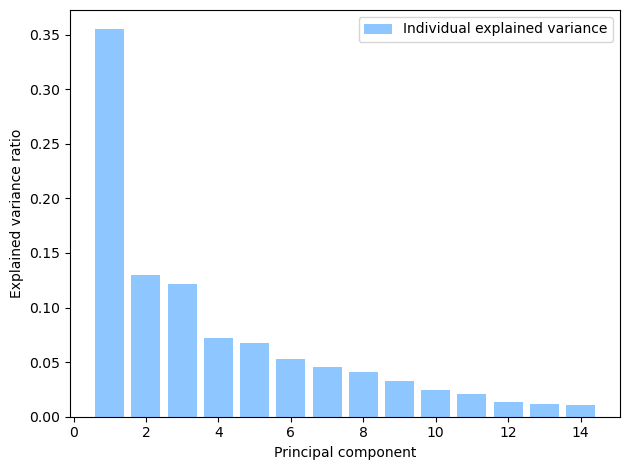

In [13]:

# Initiate the PCA.
pca = PCA()

# Fit the PCA model to determine the transformed features.
pca.fit_transform(pca_data)

# Plot variance explained by principal components
plot_explained_variances(pca)

Principal component 1 (PC1) explains over 30% of the variance in the data. PC1 is used as the basis of calculating the IER. 

In [14]:
# Inspect principal component for an SA1 (first row)

print(pca.components_[0])

[ 0.32791953  0.32001365  0.31651578  0.3077993   0.24378481  0.23155534
  0.21769425  0.1757376  -0.1520873  -0.21158613 -0.23359675 -0.28563562
 -0.29586762 -0.33499547]


In [15]:
# Reverse sign (per ABS methodology)

pca_data_transformed = -1.0*pca.fit_transform(pca_data)
    
print(pca_data_transformed[:,0])

[ 0.51729472  1.97543921 -0.30169348 ... -0.7857405  -1.70281309
 -0.11693581]


In [16]:

# Establish a dataframe of first principal component by SA1 identifier / code

pca1 = pd.DataFrame(pca_data_transformed[:,0], columns = ['IER_2021'])
#pca1.to_csv('check_pca1.csv')

IER_S1 = pd.concat([data1_IER_dropna['SA1_2021'].reset_index(drop=True), pca1]
                    , axis=1)

print(IER_S1.tail())


          SA1_2021  IER_2021
59298  90104100401  0.022187
59299  90104100402 -0.055935
59300  90104100403 -0.785740
59301  90104100404 -1.702813
59302  90104100407 -0.116936


In [17]:
# Standardise calibrated IER scores to mean of 1,000 and standard deviation of 100 (per ABS methodology)

IER_S1['IER_recreated'] = (IER_S1['IER_2021']/IER_S1['IER_2021'].std())*100+1000

print(IER_S1.tail())


          SA1_2021  IER_2021  IER_recreated
59298  90104100401  0.022187    1000.995399
59299  90104100402 -0.055935     997.490510
59300  90104100403 -0.785740     964.748521
59301  90104100404 -1.702813     923.604956
59302  90104100407 -0.116936     994.753789


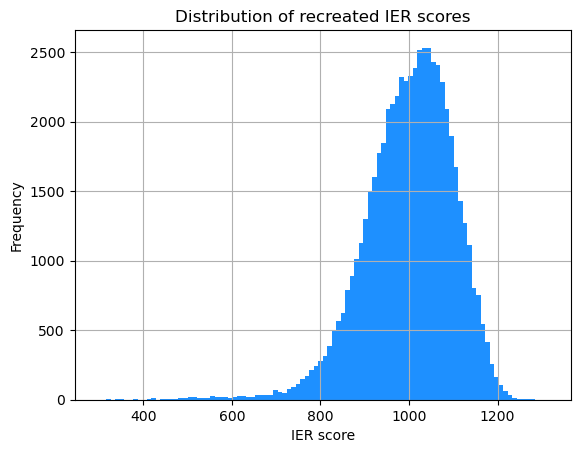

In [18]:
# Plot histogram of calibrated IER scores

IER_S1.hist(column='IER_recreated', bins=100, color='dodgerblue')
plt.title('Distribution of recreated IER scores')
plt.xlabel('IER score')
plt.ylabel('Frequency')

plt.show()


### Evaluate the model


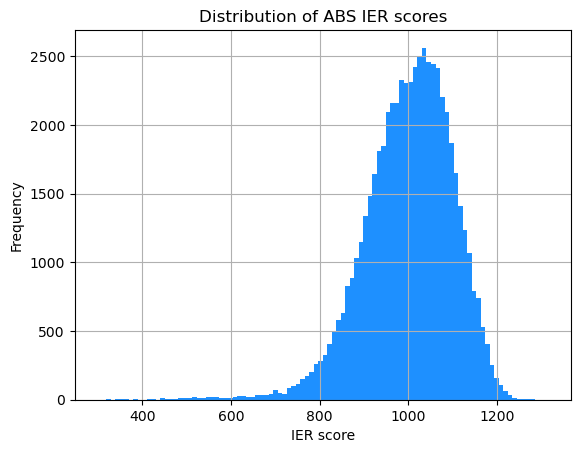

In [19]:
# Plot histogram of publisehd IER scores

ABS_IER_S1_dropna.hist(column='IER_2021', bins=100, color='dodgerblue')
plt.title('Distribution of ABS IER scores')
plt.xlabel('IER score')
plt.ylabel('Frequency')

plt.show()

ABS_IER_S1_dropna.to_csv('check_ABS_IER_S1_dropna.csv')

The two histograms are very similar in shape!

In [20]:
# Extract columns we need

IER_S1_reduce = IER_S1[['SA1_2021', 'IER_recreated']]

In [21]:
# Merge data frame (for plotting later)

IER_join = pd.merge(ABS_IER_S1_dropna, IER_S1_reduce, how = 'left', on = 'SA1_2021')

print(IER_join.tail())

#IER_join.to_csv('check.csv')

          SA1_2021     IER_2021  IER_recreated
59298  90104100401  1000.369129    1000.995399
59299  90104100402   996.979765     997.490510
59300  90104100403   964.139169     964.748521
59301  90104100404   923.050144     923.604956
59302  90104100407   994.377312     994.753789


In [22]:
# Check there's no missing value

IER_join.isna().sum()

SA1_2021         0
IER_2021         0
IER_recreated    0
dtype: int64

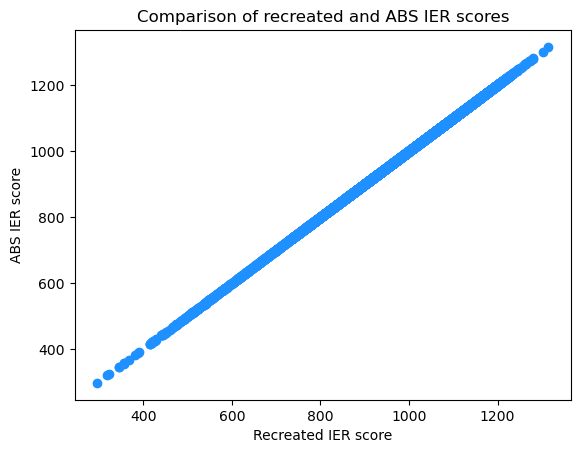

In [23]:
# Plot calibrated score vs. published score

plt.scatter('IER_recreated', 'IER_2021', data = IER_join, color='dodgerblue')
plt.title('Comparison of recreated and ABS IER scores')
plt.xlabel('Recreated IER score')
plt.ylabel('ABS IER score')

plt.show()


The above scatter plot shows that the two sets of indexes are very closely aligned.

In [24]:
# Inspect correlation

correlation, _ = pearsonr(IER_join['IER_recreated'], IER_join['IER_2021'])
print('The correlation between the ABS and recreated index is: '+str(correlation))

The correlation between the ABS and recreated index is: 0.9999962803262905
